In [2]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

import matplotlib.pyplot as plt
from random import gauss, seed

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import TimeTrend, Seasonality

plt.style.use('default')
plt.rcParams["figure.figsize"] = (8*1.618,8) #Golden ratio

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

In [4]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def my_acf_pacf_plot(series, nlags=40, ci_alpha=0.05, skip_0=False, size=(12, 10),title_add=None):
    
    nobs = series.shape[0]
    lim = min(nlags, min(int(np.ceil(12 * np.log10(nobs))), nobs - 1) )
    lags = np.arange(lim+1)
    
    
    acf_x, acf_confint = acf(series, nlags=len(lags)-1, alpha=ci_alpha)
    pacf_x, pacf_confint = pacf(series, nlags=len(lags)-1, alpha=ci_alpha, method='ywm')
    
    atitle = 'Autocorrelation'
    ptitle = 'Partial Autocorrelation'
    if title_add is not None:
        atitle = atitle + ' of ' +title_add
        ptitle = ptitle + ' of ' +title_add
    
    if skip_0:
        lags = lags[1:]
        acf_x = acf_x[1:]
        acf_confint = acf_confint[1:,]
        atitle = atitle+ '\n(lag 0 not shown)'
        
        pacf_x = pacf_x[1:]
        pacf_confint = pacf_confint[1:,]
        ptitle = ptitle+ '\n(lag 0 not shown)'
        
    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa._plot_corr(ax=ax1, title=atitle, acf_x=acf_x, confint=None, lags=lags,
                          irregular=False, use_vlines=True, vlines_kwargs={'color':'k'},
                          color='k')
    acf_lim = max(np.max(np.abs(acf_x)), np.max(np.abs(acf_confint)) )
    ax1.set_ylim(-(acf_lim*1.1), acf_lim*1.1)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa._plot_corr(ax=ax2, title=ptitle, acf_x=pacf_x, confint=None, lags=lags,
                          irregular=False, use_vlines=True, vlines_kwargs={'color':'k'},
                          color='k')
    pacf_lim = max(np.max(np.abs(pacf_x)), np.max(np.abs(pacf_confint)) )
    ax2.set_ylim(-(pacf_lim*1.1), pacf_lim*1.1)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel('Lag')
    #ax2.set_ylabel('')

    lags = lags.astype(float)
    lags[0] -= 0.5
    lags[-1] += 0.5
    ax1.plot(lags, acf_confint[:, 0] - acf_x, linestyle='dashed', color='k')
    ax1.plot(lags, acf_confint[:, 1] - acf_x, linestyle='dashed', color='k')
    ax1.fill_between(lags, acf_confint[:, 0] - acf_x, acf_confint[:, 1] - acf_x, 
                     alpha=0.2, color='k')

    ax2.plot(lags, pacf_confint[:, 0] - pacf_x, linestyle='dashed', color='k')
    ax2.plot(lags, pacf_confint[:, 1] - pacf_x, linestyle='dashed', color='k')    
    ax2.fill_between(lags, pacf_confint[:, 0] - pacf_x, pacf_confint[:, 1] - pacf_x, 
                     alpha=0.2, color='k')
    
    return fig

## Used Retail Cars Data

In [10]:
sales_df = pd.read_csv('data/MRTSSM44112USN.csv', header=0, index_col='DATE')
sales_df.index = pd.DatetimeIndex(sales_df.index.values,freq='MS')
sales_df.columns =['Sales']

In [11]:
sales_df.head()

,Sales
1992-01-01,1744
1992-02-01,1990
1992-03-01,2177
1992-04-01,2601
1992-05-01,2171


In [12]:
sales_df.tail()

,Sales
2015-02-01,9315
2015-03-01,9581
2015-04-01,9228
2015-05-01,8803
2015-06-01,8595


### Percent Change of the Series

In [13]:
sales_df['Sales_CHANGE'] = sales_df['Sales'].pct_change()

Text(1990-12-01, -0.35, 'U.S. Census Bureau, Retail Sales: Used Cars \nFRED series: MRTSSM44112USN')

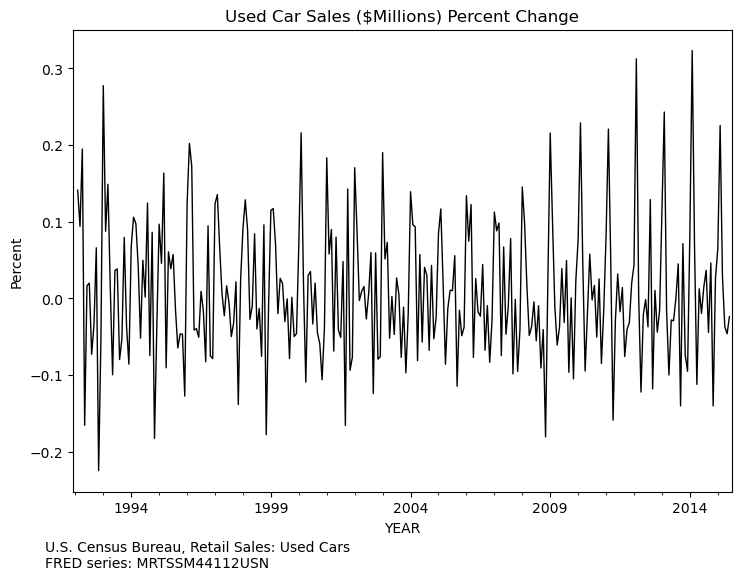

In [14]:
plt.style.use('default')

ax =sales_df.Sales_CHANGE.plot(figsize=(8.5,6), color='k',legend=False, linewidth=1)
plt.xlabel('YEAR')
plt.ylabel('Percent')
plt.title('Used Car Sales ($Millions) Percent Change')
plt.xlim('1991-12-01', '2015-07-01')
plt.text('1990-12-01', -.35,'U.S. Census Bureau, Retail Sales: Used Cars \nFRED series: MRTSSM44112USN')

#### Correlograms of series

In [15]:
#Null Hypothesis: The series has a unit root.
adfuller(sales_df.Sales_CHANGE[1:], autolag="AIC")

(-3.7526134351308214,
 0.003431102812710975,
 13,
 267,
 {'1%': -3.4550813975770827,
  '5%': -2.8724265892710914,
  '10%': -2.5725712007462582},
 -795.2779560197187)

In [16]:
#Null Hypothesis: The process is trend stationary.
kpss(sales_df.Sales_CHANGE[1:])

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.18764899142128744,
 0.1,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

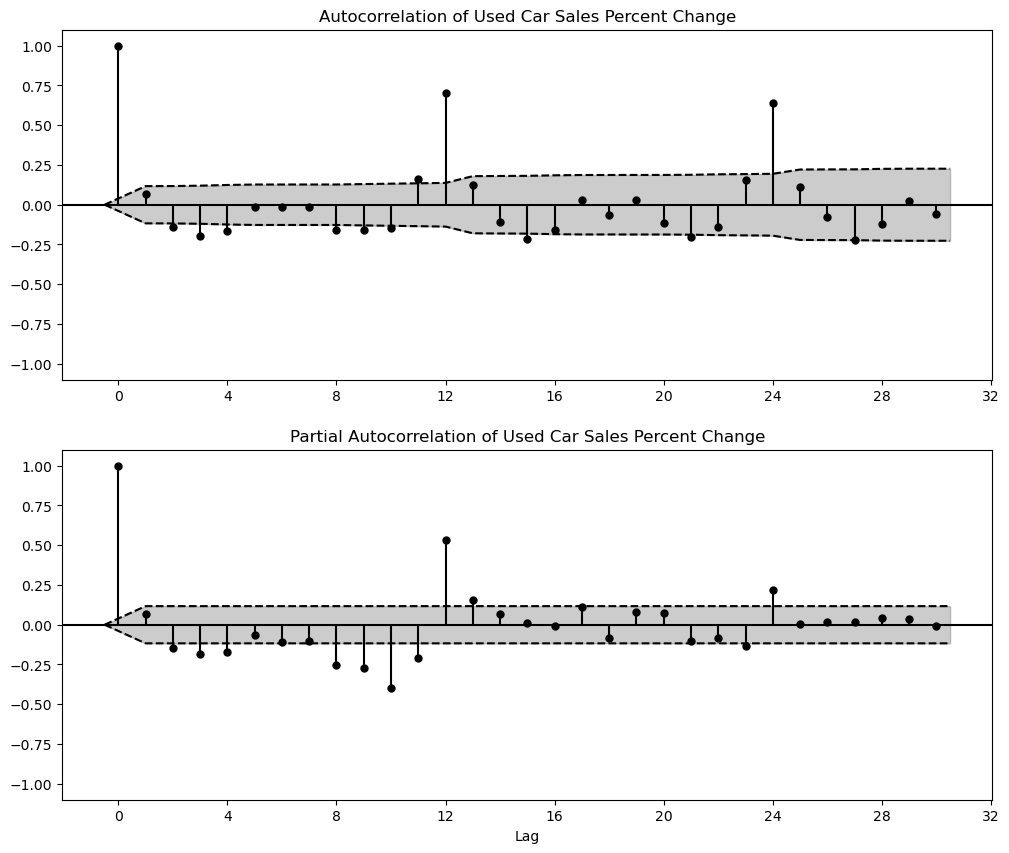

In [17]:
ax= my_acf_pacf_plot(sales_df.Sales_CHANGE[1:], title_add='Used Car Sales Percent Change')

### Using correlogram as a guide, find the best model using AIC, BIC

In [18]:
seas_gen = Seasonality(12)
seas_df = seas_gen.in_sample(sales_df.index)
seas_df.columns = ['M'+str(i+1) for i in range(12) ]
seas_df.drop(columns='M1', inplace=True)
seas_df

,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
1992-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2015-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
res_list_seas= []
for p in range(4):
    for q in range(4):
        if p>0 or q>0:
            mod = ARIMA(sales_df.Sales_CHANGE, exog=seas_df, order =(p,0,q), freq='MS')
            res = mod.fit(method_kwargs={'maxiter':1200} )

            res_list_seas.append({'p':p,'q':q, 'aic': res.aic, 'bic': res.bic})

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [20]:
pd.DataFrame(res_list_seas).groupby(['p','q'])['aic'].sum().unstack()

q,0,1,2,3
p,,,,
0,NaN,-870.748518,-871.852340,-869.885023
1,-859.276707,-871.832074,-869.852265,-867.973984
2,-870.129189,-868.194943,-867.932641,-887.219758
3,-868.146926,-869.133069,-868.218027,-891.383713


In [21]:
pd.DataFrame(res_list_seas).groupby(['p','q'])['bic'].sum().unstack()

q,0,1,2,3
p,,,,
0,NaN,-819.761819,-817.223734,-811.614509
1,-808.290008,-817.203468,-811.581752,-806.061563
2,-815.500583,-809.924430,-806.020220,-821.665431
3,-809.876413,-807.220649,-802.663699,-822.187478


In [22]:
res_list= []
for p in [10,11,12]:
    for q in range(4):
        if p>0 or q>0:
            mod = ARIMA(sales_df.Sales_CHANGE, exog=seas_df,order =(p,0,q), freq='MS')
            res = mod.fit(method_kwargs={'maxiter':2200} )

            res_list.append({'p':p,'q':q, 'aic': res.aic, 'bic': res.bic})

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
pd.DataFrame(res_list).groupby(['p','q'])['aic'].sum().unstack()

q,0,1,2,3
p,,,,
10,-881.599638,-879.716939,-882.981215,-880.371847
11,-880.194790,-877.600704,-907.400805,-904.523021
12,-890.053764,-890.796633,-911.123519,-911.638091


In [24]:
pd.DataFrame(res_list).groupby(['p','q'])['bic'].sum().unstack()

q,0,1,2,3
p,,,,
10,-797.835776,-792.311169,-791.933538,-785.682263
11,-792.789020,-786.553027,-812.711222,-806.191530
12,-799.006087,-796.107049,-812.792028,-809.664693


In [25]:
res_list= []
for q in [10,11,12]:
    for p in range(4):
        if p>0 or q>0:
            mod = ARIMA(sales_df.Sales_CHANGE, exog=seas_df,order =(p,0,q), freq='MS')
            res = mod.fit(method_kwargs={'maxiter':2200} )

            res_list.append({'p':p,'q':q, 'aic': res.aic, 'bic': res.bic})

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
pd.DataFrame(res_list).groupby(['p','q'])['aic'].sum().unstack()

q,10,11,12
p,,,
0,-876.254496,-874.783164,-884.437373
1,-874.303565,-875.298473,-883.181328
2,-884.462418,-877.112146,-882.060629
3,-883.242723,-878.336995,-880.068268


In [27]:
pd.DataFrame(res_list).groupby(['p','q'])['bic'].sum().unstack()

q,10,11,12
p,,,
0,-792.490633,-787.377395,-793.389696
1,-786.897795,-784.250796,-788.491744
2,-793.414741,-782.422562,-783.729139
3,-788.553139,-780.005504,-778.094870


## Conclusion: ARMA(3,3) has best BIC, but ARMA(11,2) has best AIC.

# ARMA(3,3)
top BIC model

In [28]:
mod = ARIMA(sales_df.Sales_CHANGE, order =(3,0,3), exog=seas_df, freq='MS')
res = mod.fit(method_kwargs={'maxiter':2600} )
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sales_CHANGE   No. Observations:                  282
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 464.692
Date:                Thu, 09 Mar 2023   AIC                           -891.384
Time:                        18:09:54   BIC                           -822.187
Sample:                    01-01-1992   HQIC                          -863.635
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1402      0.016      8.852      0.000       0.109       0.171
M2             0.0272      0.023      1.184      0.237      -0.018       0.072
M3            -0.1127      0.031     -3.641      0.000      -0.173      -0.052
M4            -0.1717      0.015    -11.784      0.000      -0.200      -0.143
M5            -0.1297      0.021     -6.103      0.000      -0.171      -0.088
M6            -0.1763      0.031     -5.728      0.000      -0.237      -0.116
M7            -0.1267      0.020     -6.301      0.000      -0.166      -0.087
M8            -0.0966      0.019     -4.969      0.000      -0.135      -0.058
M9            -0.2613      0.033     -7.856      0.000      -0.326      -0.196
M10           -0.0944      0.015     -6.475      0.000      -0.123      -0.066
M11           -0.2174      0.021    -10.436      0.000      -0.258      -0.177
M12           -0.2148      0.033     -6.521      0.000      -0.279      -0.150
ar.L1         -0.5862      0.135     -4.345      0.000      -0.851      -0.322
ar.L2         -0.5623      0.137     -4.094      0.000      -0.832      -0.293
ar.L3          0.4287      0.134      3.193      0.001       0.166       0.692
ma.L1          0.2620      0.103      2.544      0.011       0.060       0.464
ma.L2          0.2998      0.098      3.062      0.002       0.108       0.492
ma.L3         -0.7034      0.105     -6.687      0.000      -0.910      -0.497
sigma2         0.0021      0.000      9.871      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.11
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.59
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, 'Year')

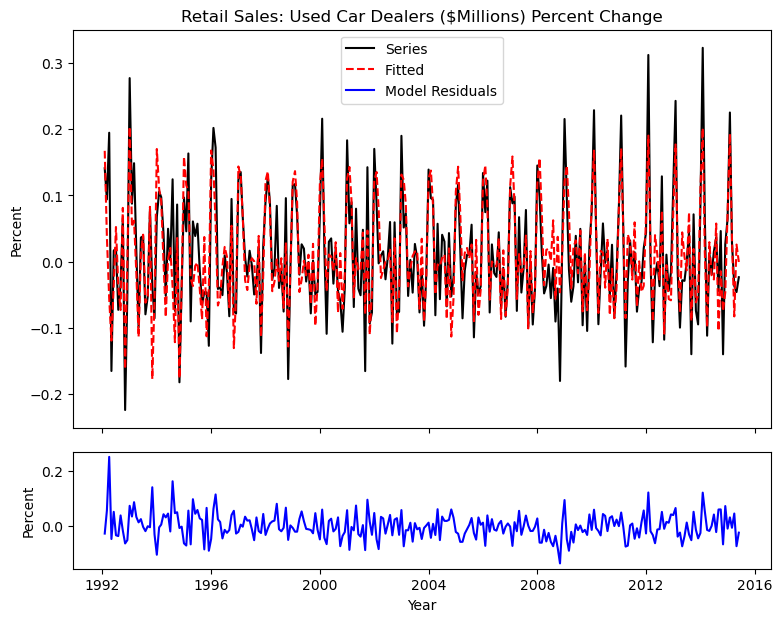

In [29]:
plt.rcParams['figure.figsize'] =(9,7)


gs=GridSpec(4,2) # 2 rows, 3 columns
fig=plt.figure()
ax = fig.add_subplot(gs[:3,:]) 
ax.plot(sales_df.Sales_CHANGE, color='k', label='Series')
ax.plot(res.fittedvalues[1:], color='r', ls='--', label='Fitted ')
ax.xaxis.set_tick_params(labelbottom=False)
plt.title('Retail Sales: Used Car Dealers ($Millions) Percent Change')
plt.ylabel('Percent')
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0],color='b'))
labels.append('Model Residuals')
plt.legend(handles, labels)

ax2 = fig.add_subplot(gs[3,:])
ax2.plot(res.resid[1:], color='b',)
#plt.title('Model Residuals')
plt.ylabel('Percent')
plt.xlabel('Year')

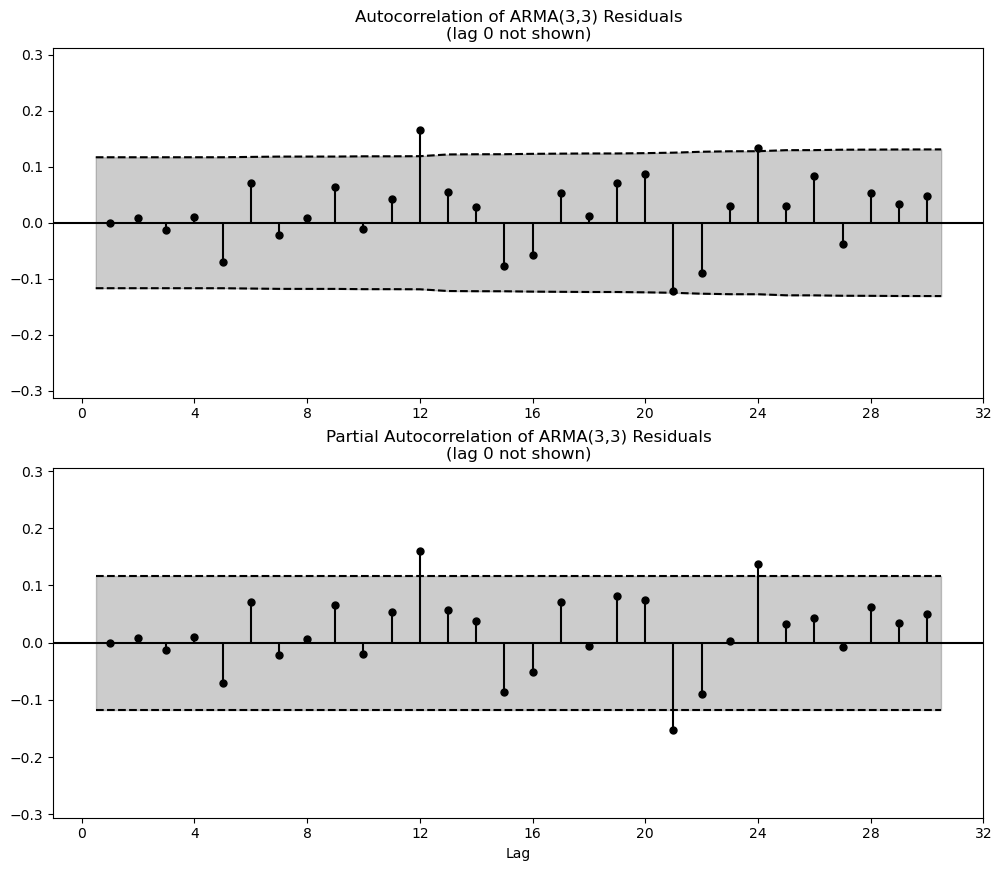

In [30]:
ax= my_acf_pacf_plot(res.resid[1:], title_add='ARMA(3,3) Residuals', skip_0=True)

In [31]:
exog_NoM2 = seas_df.drop(['M2'],axis=1)

mod3 = ARIMA(sales_df.Sales_CHANGE, order =(3,0,3), exog=exog_NoM2, freq='MS')
res3 = mod3.fit(method_kwargs={'maxiter':2600} )
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sales_CHANGE   No. Observations:                  282
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 463.720
Date:                Thu, 09 Mar 2023   AIC                           -891.440
Time:                        18:09:59   BIC                           -825.886
Sample:                    01-01-1992   HQIC                          -865.152
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1570      0.013     11.687      0.000       0.131       0.183
M3            -0.1350      0.037     -3.604      0.000      -0.208      -0.062
M4            -0.1781      0.013    -13.498      0.000      -0.204      -0.152
M5            -0.1503      0.012    -12.909      0.000      -0.173      -0.127
M6            -0.1994      0.036     -5.477      0.000      -0.271      -0.128
M7            -0.1333      0.019     -7.056      0.000      -0.170      -0.096
M8            -0.1170      0.013     -9.165      0.000      -0.142      -0.092
M9            -0.2846      0.039     -7.336      0.000      -0.361      -0.209
M10           -0.1012      0.014     -7.206      0.000      -0.129      -0.074
M11           -0.2381      0.012    -20.195      0.000      -0.261      -0.215
M12           -0.2390      0.038     -6.225      0.000      -0.314      -0.164
ar.L1         -0.5924      0.136     -4.369      0.000      -0.858      -0.327
ar.L2         -0.5733      0.138     -4.153      0.000      -0.844      -0.303
ar.L3          0.4194      0.135      3.099      0.002       0.154       0.685
ma.L1          0.2645      0.101      2.612      0.009       0.066       0.463
ma.L2          0.3032      0.095      3.195      0.001       0.117       0.489
ma.L3         -0.6944      0.100     -6.969      0.000      -0.890      -0.499
sigma2         0.0021      0.000     11.536      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARMA(11,2) top AIC

In [32]:
mod = ARIMA(sales_df.Sales_CHANGE, order =(11,0,2), exog=seas_df,freq='MS')
res = mod.fit(method_kwargs={'maxiter':2200} )
res.summary()

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sales_CHANGE   No. Observations:                  282
Model:                ARIMA(11, 0, 2)   Log Likelihood                 479.700
Date:                Thu, 09 Mar 2023   AIC                           -907.401
Time:                        18:10:13   BIC                           -812.711
Sample:                    01-01-1992   HQIC                          -869.429
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1257      0.016      7.948      0.000       0.095       0.157
M2             0.0254      0.025      1.010      0.313      -0.024       0.075
M3            -0.0610      0.025     -2.401      0.016      -0.111      -0.011
M4            -0.1739      0.014    -12.539      0.000      -0.201      -0.147
M5            -0.1356      0.025     -5.476      0.000      -0.184      -0.087
M6            -0.1286      0.028     -4.603      0.000      -0.183      -0.074
M7            -0.1277      0.015     -8.340      0.000      -0.158      -0.098
M8            -0.0981      0.026     -3.704      0.000      -0.150      -0.046
M9            -0.2094      0.026     -7.910      0.000      -0.261      -0.157
M10           -0.0957      0.013     -7.406      0.000      -0.121      -0.070
M11           -0.2276      0.025     -9.260      0.000      -0.276      -0.179
M12           -0.1668      0.027     -6.114      0.000      -0.220      -0.113
ar.L1          0.5767      0.064      9.006      0.000       0.451       0.702
ar.L2         -0.7436      0.069    -10.740      0.000      -0.879      -0.608
ar.L3         -0.1698      0.095     -1.793      0.073      -0.355       0.016
ar.L4         -0.2670      0.091     -2.920      0.003      -0.446      -0.088
ar.L5         -0.1477      0.091     -1.625      0.104      -0.326       0.030
ar.L6          0.1301      0.094      1.378      0.168      -0.055       0.315
ar.L7         -0.3727      0.090     -4.138      0.000      -0.549      -0.196
ar.L8          0.1165      0.085      1.375      0.169      -0.049       0.282
ar.L9          0.0252      0.083      0.303      0.762      -0.138       0.188
ar.L10        -0.2862      0.067     -4.275      0.000      -0.417      -0.155
ar.L11         0.2094      0.066      3.191      0.001       0.081       0.338
ma.L1         -0.9805      0.032    -30.808      0.000      -1.043      -0.918
ma.L2          0.9625      0.036     26.748      0.000       0.892       1.033
sigma2         0.0019      0.000     11.247      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                49.74
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.60
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, 'Year')

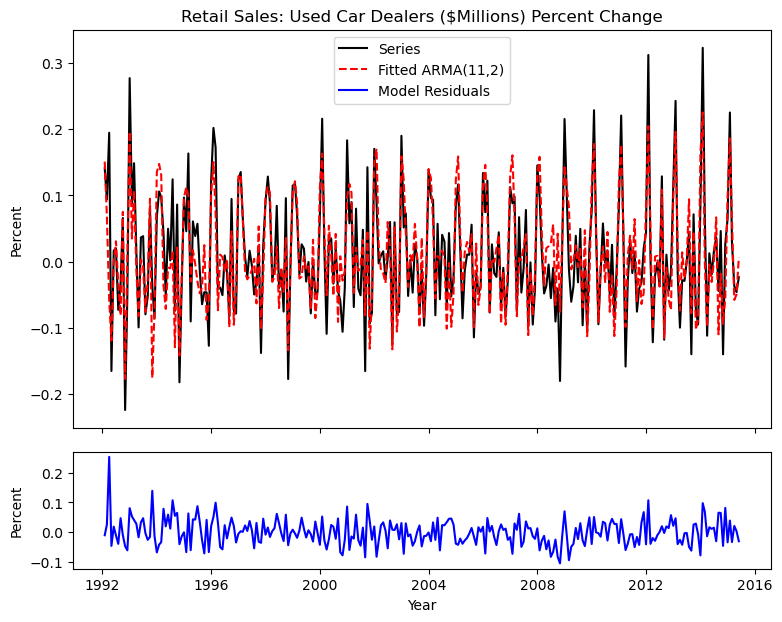

In [35]:
plt.rcParams['figure.figsize'] =(9,7)


gs=GridSpec(4,2) # 2 rows, 3 columns
fig=plt.figure()
ax = fig.add_subplot(gs[:3,:]) 
ax.plot(sales_df.Sales_CHANGE, color='k', label='Series')
ax.plot(res.fittedvalues[1:], color='r', ls='--', label='Fitted ARMA(11,2)')
ax.xaxis.set_tick_params(labelbottom=False)
plt.title('Retail Sales: Used Car Dealers ($Millions) Percent Change')
plt.ylabel('Percent')
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0],color='b'))
labels.append('Model Residuals')
plt.legend(handles, labels)

ax2 = fig.add_subplot(gs[3,:])
ax2.plot(res.resid[1:], color='b',)
#plt.title('Model Residuals')
plt.ylabel('Percent')
plt.xlabel('Year')

In [36]:
ar_mask = (1,1,0,1,0,0,1,0,0,1,1)
month_mask = seas_df.drop(['M2'],axis=1)
mod2 = ARIMA(sales_df.Sales_CHANGE, order =(ar_mask,0,2), exog=month_mask,freq='MS')
res2 = mod2.fit(method_kwargs={'maxiter':2200} )
res2.summary()

C:\Users\vince\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                          Sales_CHANGE   No. Observations:                  282
Model:             ARIMA([1, 2, 4, 7, 10, 11], 0, 2)   Log Likelihood                 453.990
Date:                               Thu, 09 Mar 2023   AIC                           -867.980
Time:                                       18:16:26   BIC                           -795.142
Sample:                                   01-01-1992   HQIC                          -838.771
                                        - 06-01-2015                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1354      0.006     20.873      0.000       0.123       0.148
M3            -0.0673      0.015     -4.343      0.000      -0.098      -0.037
M4            -0.1824      0.011    -16.100      0.000      -0.205      -0.160
M5            -0.1453      0.014    -10.117      0.000      -0.173      -0.117
M6            -0.1337      0.017     -7.960      0.000      -0.167      -0.101
M7            -0.1388      0.018     -7.526      0.000      -0.175      -0.103
M8            -0.1124      0.014     -7.873      0.000      -0.140      -0.084
M9            -0.2157      0.017    -12.667      0.000      -0.249      -0.182
M10           -0.1075      0.012     -8.632      0.000      -0.132      -0.083
M11           -0.2340      0.013    -17.460      0.000      -0.260      -0.208
M12           -0.1702      0.016    -10.859      0.000      -0.201      -0.140
ar.L1          1.0073      0.250      4.023      0.000       0.517       1.498
ar.L2         -0.1135      0.180     -0.631      0.528      -0.466       0.239
ar.L4         -0.0358      0.069     -0.520      0.603      -0.171       0.099
ar.L7          0.0402      0.047      0.862      0.389      -0.051       0.132
ar.L10        -0.1169      0.069     -1.692      0.091      -0.252       0.019
ar.L11         0.1657      0.060      2.778      0.005       0.049       0.283
ma.L1         -1.4027      0.240     -5.833      0.000      -1.874      -0.931
ma.L2          0.4481      0.233      1.920      0.055      -0.009       0.906
sigma2         0.0023      0.000     12.782      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                71.37
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.69
Prob(H) (two-sided):                  0.43   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, 'Year')

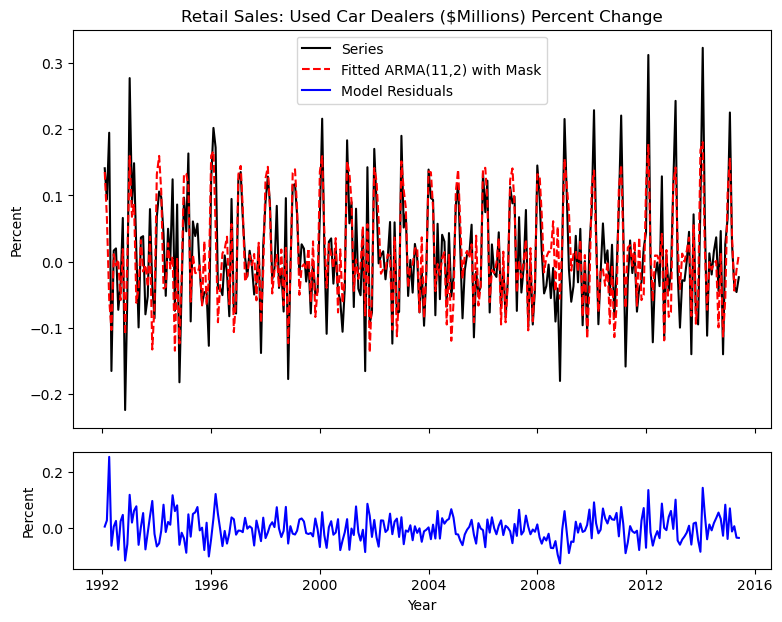

In [37]:
plt.rcParams['figure.figsize'] =(9,7)


gs=GridSpec(4,2) # 2 rows, 3 columns
fig=plt.figure()
ax = fig.add_subplot(gs[:3,:]) 
ax.plot(sales_df.Sales_CHANGE, color='k', label='Series')
ax.plot(res2.fittedvalues[1:], color='r', ls='--', label='Fitted ARMA(11,2) with Mask')
ax.xaxis.set_tick_params(labelbottom=False)
plt.title('Retail Sales: Used Car Dealers ($Millions) Percent Change')
plt.ylabel('Percent')
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0],color='b'))
labels.append('Model Residuals')
plt.legend(handles, labels)

ax2 = fig.add_subplot(gs[3,:])
ax2.plot(res2.resid[1:], color='b',)
#plt.title('Model Residuals')
plt.ylabel('Percent')
plt.xlabel('Year')

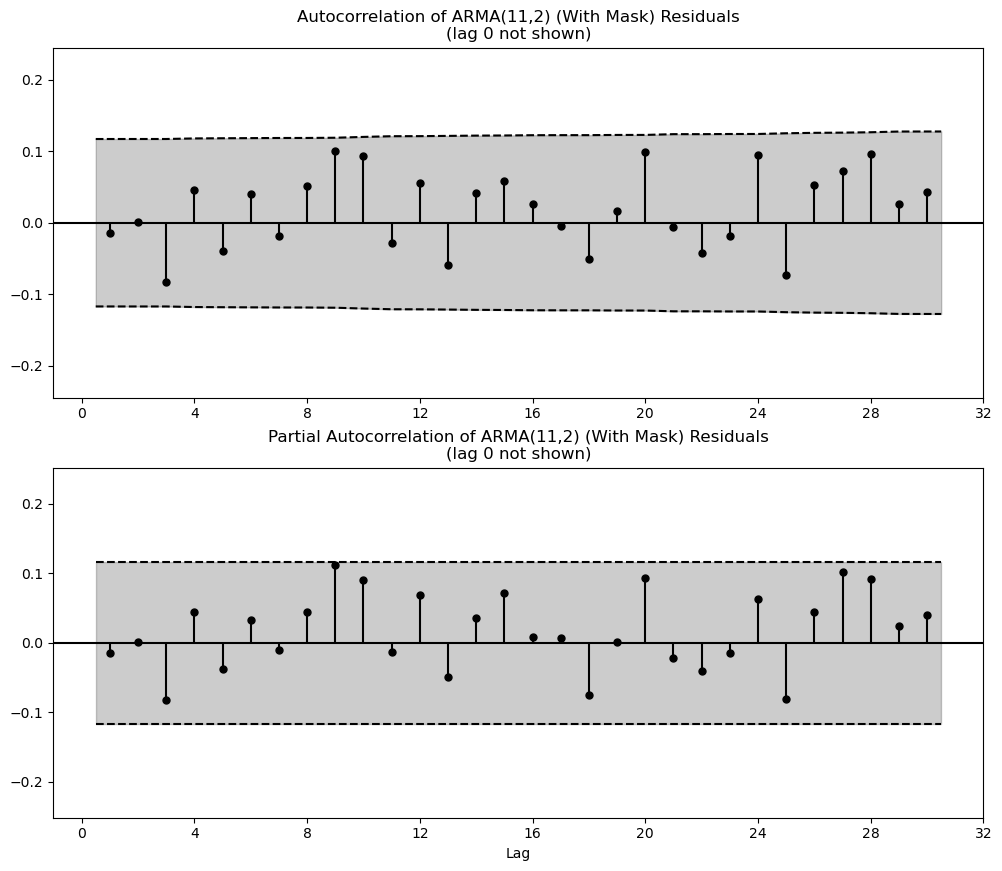

In [34]:
ax= my_acf_pacf_plot(res2.resid[1:], skip_0=True, title_add='ARMA(11,2) (With Mask) Residuals')